In [28]:
#импортируем библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
from scipy.stats import ttest_ind


In [29]:
df = pd.read_csv("/kaggle/input/grocery-website-data-for-ab-test/grocerywebsiteabtestdata.csv")


Смотрим статистику

In [30]:
def df_stats(data):
    print("***РАЗМЕР***")
    print("Строк: {}".format(data.shape[0]))
    print("Столбцов: {}".format(data.shape[1]))
    print("***ТИПЫ ДАННЫХ***")
    print(data.dtypes)
    print("***ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ***")
    print(data.isnull().sum())
    print("***ЧИСЛО ДУБЛИКАТОВ***")
    print("Количество дубликатов: {}".format(data.duplicated().sum()))
    

In [31]:
df_stats(df)

***РАЗМЕР***
Строк: 184588
Столбцов: 5
***ТИПЫ ДАННЫХ***
RecordID          int64
IP Address       object
LoggedInFlag      int64
ServerID          int64
VisitPageFlag     int64
dtype: object
***ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ***
RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64
***ЧИСЛО ДУБЛИКАТОВ***
Количество дубликатов: 0


In [32]:
print(df["VisitPageFlag"].unique())  # Посмотрим, какие есть уникальные значения
print(df["VisitPageFlag"].sum())  # Проверим, есть ли вообще ненулевые значения


[0 1]
10740


Посмотреть распределение пользователей по серверам:


ServerID
1    61591
3    61534
2    61463
Name: count, dtype: int64


<Axes: ylabel='count'>

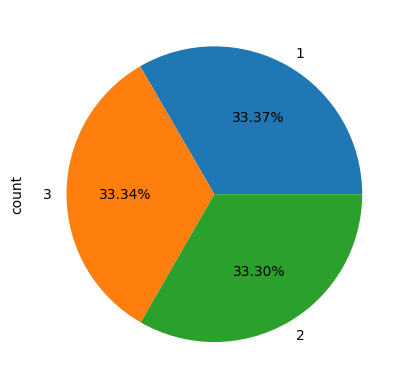

In [33]:
print(df["ServerID"].value_counts())
df["ServerID"].value_counts().plot(kind="pie", autopct="%.2f%%")

Проверить, различается ли поведение пользователей на серверах

In [34]:
df.groupby("ServerID")["VisitPageFlag"].mean()

ServerID
1    0.067640
2    0.053300
3    0.053596
Name: VisitPageFlag, dtype: float64

Серверы 2 и 3 могут быть одинаковыми, т.е. они работают как зеркала (обрабатывают один и тот же продукт).
Это нужно для стабильности работы и балансировки нагрузки.

Не будем делать индекс в groupby(), используем as_index=False, чтобы при группировке он сам его не создавал:

In [35]:
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"], as_index=False)["VisitPageFlag"].sum().rename(columns={"VisitPageFlag": "VisitPageFlagSum"})

In [36]:
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [37]:
# Cоздаём булевый массив (True для ненулевых значений, False для нулей)
df["VisitPageFlag"] = (df["VisitPageFlagSum"] != 0).astype(int)
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


Test (1) → получает новую функцию, дизайн или изменения.  
Control (2, 3) → остаётся на старой версии, чтобы сравнить результат.  


Разделим датафрейм на тестовую (df_test) и контрольную (df_control) группы, создадим их копии с обновлёнными индексами в одном цикле для оптимизации.

In [38]:
df['group'] = df['ServerID'].map({1: 'Test', 2: 'Control', 3: 'Control'})

groups = {group: df[df['group'] == group].reset_index(drop=True) for group in ['Control', 'Test']}

df_control = groups['Control']
df_test = groups['Test']


In [39]:
df_control.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag,group
0,0.0.111.8,0,3,0,0,Control
1,0.0.160.9,1,2,0,0,Control
2,0.0.163.1,0,2,0,0,Control
3,0.0.178.9,1,2,0,0,Control
4,0.0.185.4,1,3,0,0,Control


In [40]:
df_test.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag,group
0,0.0.108.2,0,1,0,0,Test
1,0.0.109.6,1,1,0,0,Test
2,0.0.169.1,1,1,0,0,Test
3,0.0.181.9,0,1,1,1,Test
4,0.0.195.5,1,1,0,0,Test


In [41]:
df_control.describe().T # Транспонируем

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,66460.0,0.503912,0.499988,0.0,0.0,1.0,1.0,1.0
ServerID,66460.0,2.500692,0.500003,2.0,2.0,3.0,3.0,3.0
VisitPageFlagSum,66460.0,0.098917,0.320759,0.0,0.0,0.0,0.0,3.0
VisitPageFlag,66460.0,0.092251,0.289382,0.0,0.0,0.0,0.0,1.0


In [42]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,33303.0,0.503258,0.499997,0.0,0.0,1.0,1.0,1.0
ServerID,33303.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
VisitPageFlagSum,33303.0,0.125094,0.359371,0.0,0.0,0.0,0.0,4.0
VisitPageFlag,33303.0,0.115515,0.319647,0.0,0.0,0.0,0.0,1.0


Посчитаем общее число посещений в контрольной группе.
Сколько пользователей совершили целевое действие (VisitPageFlag = 1). 

Sum visit for control group: 66460
Visit Page target = 1: 6131


<Axes: ylabel='count'>

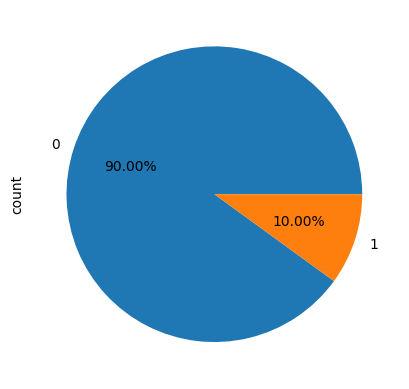

In [43]:
control_sum_visit, control_visit_1 = df_control['VisitPageFlag'].agg(['count', lambda x: (x == 1).sum()])
print(f"Sum visit for control group: {control_sum_visit}")
print(f"Visit Page target = 1: {control_visit_1}")
df["VisitPageFlag"].value_counts().plot(kind="pie", autopct="%.2f%%")

Посчитаем конверсию в контрольной группе:

In [44]:
control_ratio_visit = control_visit_1/control_sum_visit
round(control_ratio_visit, 4)

0.0923

Посчитаем общее число посещений в тестовой группе.
Сколько пользователей совершили целевое действие (VisitPageFlag = 1). 

Sum visit for test group: 33303
Visit Page target = 1: 3847


<Axes: ylabel='count'>

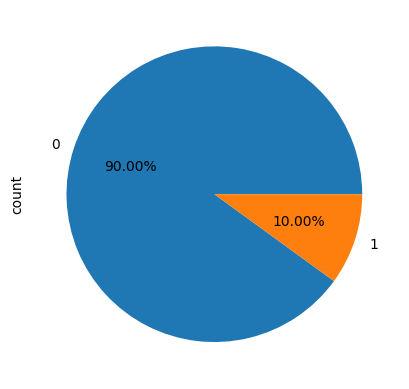

In [45]:
test_sum_visit, test_visit_1 = df_test['VisitPageFlag'].agg(['count', lambda x: (x == 1).sum()])
print(f"Sum visit for test group: {test_sum_visit}")
print(f"Visit Page target = 1: {test_visit_1}")
df["VisitPageFlag"].value_counts().plot(kind="pie", autopct="%.2f%%")

In [46]:
test_ratio_visit = test_visit_1/test_sum_visit
round(test_ratio_visit, 4)


0.1155

Выполним тест Шапиро-Уилка на нормальность распределения значений в столбце "VisitPageFlag" из контрольной группы (df_control).
Подсчитаем test_stat в тесте Шапиро-Уилка, числовой показатель, который измеряет, насколько сильно распределение данных отклоняется от нормального.

Если test_stat близок к 1 → распределение почти нормальное.
Если test_stat значительно меньше 1 → данные сильно отклоняются от нормального распределения.

In [47]:
from scipy.stats import shapiro

# Функция для теста Шапиро-Уилка и интерпретации результата
def check_normality(data, label="Dataset"):
    test_stat, pvalue = shapiro(data)
    print(f"{label}: Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}")
    print("Данные нормально распределены." if pvalue > 0.05 else "Данные НЕ являются нормально распределёнными.")
    print("-" * 50)

# Проверяем обе выборки
check_normality(df_control["VisitPageFlag"], "Control Group")
check_normality(df_test["VisitPageFlag"], "Test Group")


Control Group: Test Stat = 0.3267, p-value = 0.0000
Данные НЕ являются нормально распределёнными.
--------------------------------------------------
Test Group: Test Stat = 0.3711, p-value = 0.0000
Данные НЕ являются нормально распределёнными.
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 66460.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 33303.
  res = hypotest_fun_out(*samples, **kwds)


Оба значения Test Stat значительно меньше 1, что указывает на сильное отклонение от нормального распределения.

Будем использовать непараметрические тесты вместо t-теста (Манна-Уитни).


In [48]:
# Функция для теста Манна-Уитни
def mann_whitney_test(group1, group2, label1="Control", label2="Test"):
    test_stat, pvalue = mannwhitneyu(group1, group2)
    print(f"{label1} vs {label2}: Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}")

mann_whitney_test(df_control["VisitPageFlag"], df_test["VisitPageFlag"], "Control Group", "Test Group")


Control Group vs Test Group: Test Stat = 1080913226.5000, p-value = 0.0000


Интересно всё же попробовать провести Т-тест:

In [49]:
# Выполняем t-тест для независимых выборок
test_stat, pvalue = ttest_ind(df_control["VisitPageFlag"], df_test["VisitPageFlag"], equal_var=False)
print(f"T-test: Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}")


T-test: Test Stat = -11.1825, p-value = 0.0000


Создадим кросс-таблицу

In [50]:
groupped = pd.crosstab(
    df['group'], df['VisitPageFlag'], margins=True, margins_name="Total"
)
percent_distribution = 100 * groupped.div(groupped['Total'], axis=0)

percent_distribution


VisitPageFlag,0,1,Total
group,,,
Control,90.774902,9.225098,100.0
Test,88.448488,11.551512,100.0
Total,89.998296,10.001704,100.0


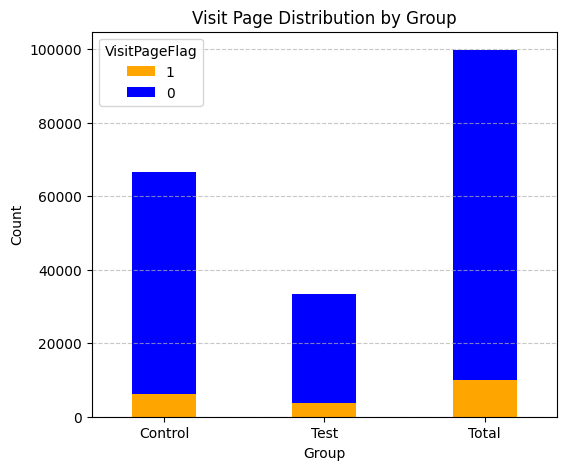

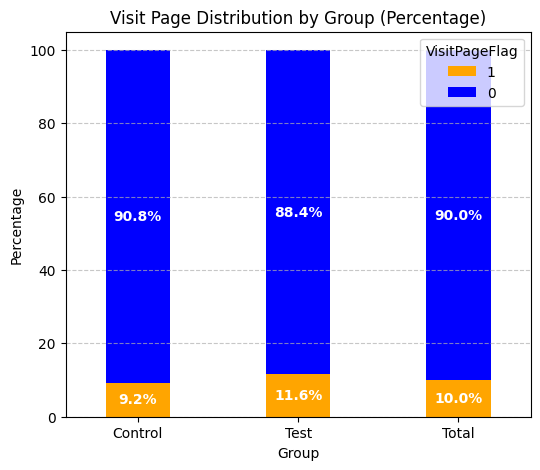

In [51]:
# Сделаем в графическом виде
groupped = groupped[[1, 0]]
groupped.plot(kind='bar', stacked=True, figsize=(6, 5), color=['orange', 'blue'], width=0.4)
plt.title("Visit Page Distribution by Group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="VisitPageFlag", labels=["1", "0"])  # Переименовали легенду
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

groupped_percentage = groupped.div(groupped.sum(axis=1), axis=0) * 100

groupped_percentage = groupped_percentage[[1, 0]]

ax = groupped_percentage.plot(kind='bar', stacked=True, figsize=(6, 5), color=['orange', 'blue'], width=0.4)

plt.title("Visit Page Distribution by Group (Percentage)")
plt.xlabel("Group")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.legend(title="VisitPageFlag", labels=["1", "0"])  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, container in enumerate(ax.containers):
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height / 2, 
                    f'{height:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

plt.show()

### Control Group:  
90.77% пользователей не выполнили действие (VisitPageFlag = 0).
9.23% пользователей выполнили (VisitPageFlag = 1).

### Test Group:
88.45% пользователей не выполнили действие.
11.55% выполнили.

### Общий итог (Total):

В среднем по всем данным 89.99% пользователей не перешли.
10.00% перешли.

### О чем это говорит?

**В тестовой группе процент пользователей, выполнивших действие, выше**

 Рост с **9.23%** до **11.55%**.
 Разница составляет:    
  `11.55% - 9.23% = 2.32%`.
  
 Относительное улучшение (Uplift):   
  `11.55 - 9.23/9.23 * 100 = 25.1%`
 
  Это означает, что тестовое изменение увеличило выполнение целевого действия на **~25.1%**.

**Тестовые изменения (новый вариант) оказали положительное влияние**

Разница небольшая, но значимая (судя по результатам статистических тестов).  
Если разница подтверждена **Манна-Уитни** и **t-тестом**, можно говорить о статистически значимом эффекте.  
 